In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.interpolate import interp1d, splrep, splev
import pandas as pd

%load_ext autoreload
%autoreload 2
from utils import *

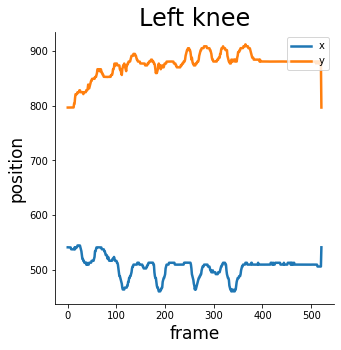

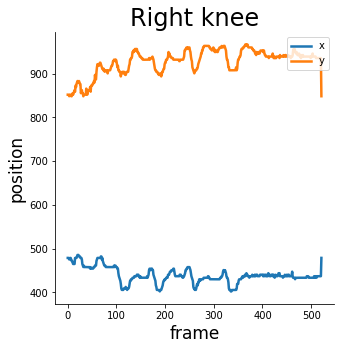

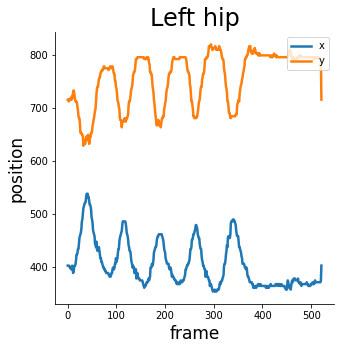

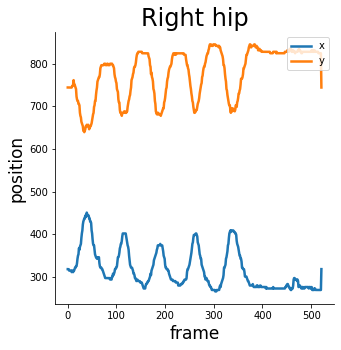

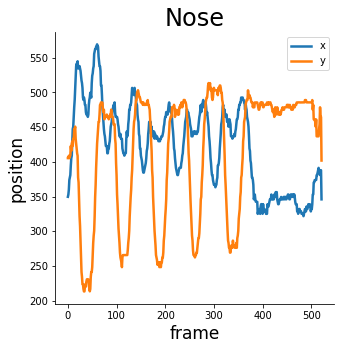

In [2]:
# Convert OpenPose frames to a numpy array
res = np.load("videos/np/cIZijMLk.npy")

# Features to plot for diagnostics
PLOT_COLS = {
    "Left knee": LKNE,
    "Right knee": RKNE,
    "Left hip": LHIP,
    "Right hip": RHIP,
    "Nose": NOSE,
}

for name, col in PLOT_COLS.items():
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.title(name,fontsize=24)
    plt.xlabel("frame",fontsize=17)
    plt.ylabel("position",fontsize=17)
    plt.plot(res[:,[col*3,]], linestyle="-", linewidth=2.5)
    plt.plot(res[:,[col*3+1,]], linestyle="-", linewidth=2.5)
    plt.legend(['x', 'y'],loc=1)

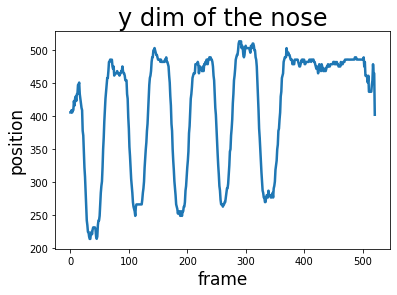

In [3]:
# Detect peaks in the nose signal
nose_y = res[:,[NOSE*3+1,]]
plt.title("y dim of the nose",fontsize=24)
plt.xlabel("frame",fontsize=17)
plt.ylabel("position",fontsize=17)
plt.plot(nose_y, linestyle="-", linewidth=2.5)

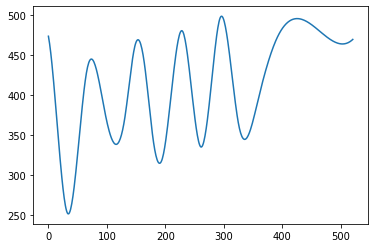

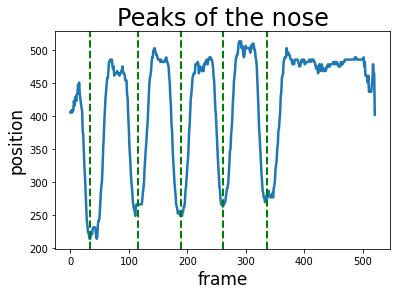

Number of sit-to-stands = 5
Time ~ 12.58s


In [4]:
x=range(len(nose_y))
f = splrep(x, nose_y, s=10**6)
plt.plot(x, splev(x, f))
plt.show()
nose_y_smooth = splev(x, f)
_,peaks = peakdet(nose_y_smooth, 50)

plt.title("Peaks of the nose",fontsize=24)
plt.xlabel("frame",fontsize=17)
plt.ylabel("position",fontsize=17)
plt.plot(nose_y, linestyle="-", linewidth=2.5)
for i in range(peaks.shape[0]):
    plt.axvline(x=peaks[i,0],linewidth=2, color='g', linestyle="--")
plt.show()

n = peaks.shape[0]

# TODO we can get a better estimate of breaks from multiple signals at once
breaks = peaks[:,0].astype(np.uint16)
breaks.sort()

print("Number of sit-to-stands = {}".format(n))
first = breaks[0]
last = breaks[-1]

# Approximated 
time = n*(last-first)/((n-1)*FPS)
print("Time ~ {}s".format( round(time,2) ))

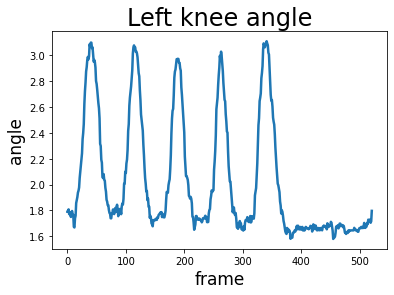

In [5]:
lkneeangle = get_angle(LANK, LKNE, LHIP, res)
plt.title("Left knee angle",fontsize=24)
plt.xlabel("frame",fontsize=17)
plt.ylabel("angle",fontsize=17)
plt.plot(lkneeangle, linestyle="-", linewidth=2.5)
plt.show()

Text(0.5, 1.0, 'L knee flex of sit-to-stands')

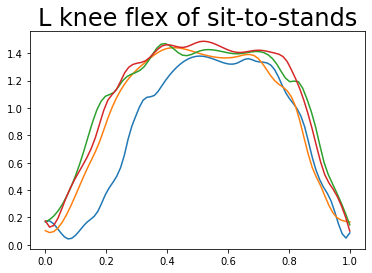

In [6]:
for i in range(len(breaks)-1):
    x = np.linspace(0, 1, num=breaks[i+1] - breaks[i], endpoint=True)
    y = np.pi - lkneeangle[breaks[i]:breaks[i+1]]
    f = splrep(x, y, s=0.03)
    xplot = np.linspace(0, 1, num=breaks[i+1] - breaks[i], endpoint=True)
    plt.plot(xplot, splev(xplot, f))
plt.title("L knee flex of sit-to-stands",fontsize=24)

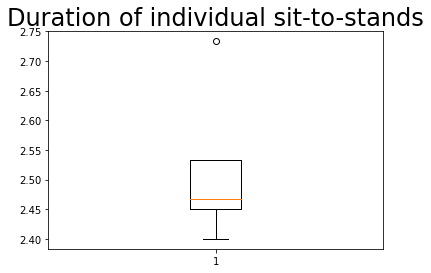

In [7]:
plt.title("Duration of individual sit-to-stands",fontsize=24)
s2s_times = (breaks[1:] - breaks[:-1])/FPS
bstats = plt.boxplot(s2s_times)
plt.show()

print("Consistency index = {}".format(1 - s2s_times.std() / s2s_times.mean()))